In [1]:
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageEnhance

from universal.data_loading import download_training_data, download_testing_data, get_trainval_dataset, \
    get_test_dataset, VOCDataset, test_transforms, train_transforms, classes, universal_transforms, normalize
from universal.deepfool import deepfool
from universal.plot import plot_images
from universal.universal_pert import universal_perturbation
from universal.vgg11_model import *
import logging
import torch
import torch.nn as nn
from torch.utils.data import RandomSampler, DataLoader, Subset
import argparse
import torchvision.models as models
import random

In [2]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)
OUTPUT_DIM = 20
device = 'cpu'
model = VGG(vgg11_layers, OUTPUT_DIM, device)

In [3]:
train_data_df, valid_data_df = get_trainval_dataset('.data/VOC2012')
# test_data_df = get_test_dataset(args.test_data)

train_data = VOCDataset(train_data_df, '.data/VOC2012', train_transforms)
valid_data = VOCDataset(valid_data_df, '.data/VOC2012', test_transforms)

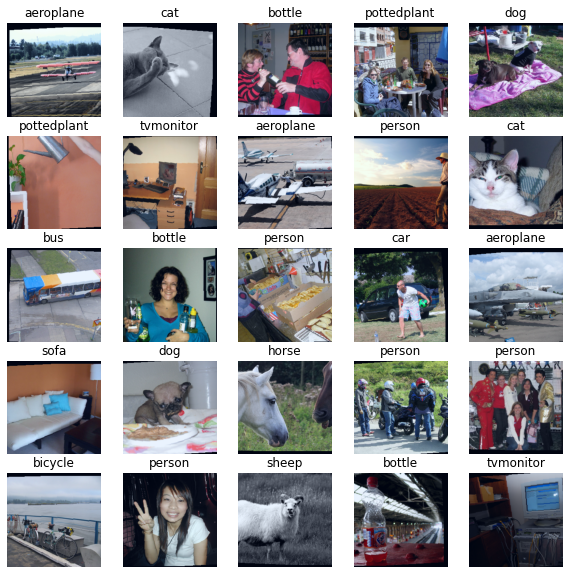

In [4]:
images, labels = zip(*[(image, label) for image, label in
                               [train_data[i] for i in random.sample(range(len(train_data)), 25)]])

plot_images(images, labels, classes)

In [5]:
torch.cuda.empty_cache()
model.load_state_dict(torch.load('vg11-voc2012-model.pt'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [6]:
plt.style.use('seaborn-white')

In [7]:
def classifier(img):
    if img.ndim == 3:
        img = img.unsqueeze(0)
    img = normalize(img)
    v = model(img)[0]
    return v

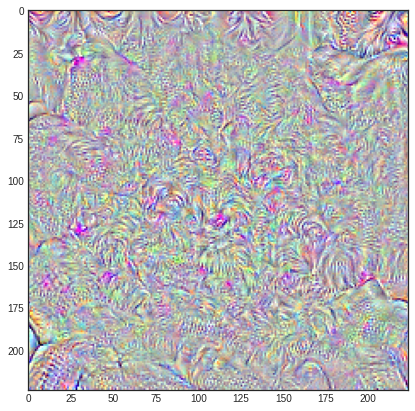

In [8]:
def change_contrast(img, factor):
    return np.clip(128 + factor * img - factor * 128, 0, 255).astype(np.uint8)

#valid_data.transform = universal_transforms
v = np.load('_p.npy')
a = v.squeeze().transpose(1, 2, 0)

#logging.info(f"Perturbation vector norm = {np.linalg.norm(abs(a))}")
#a = np.abs(a)
perturbation = (((a - np.min(a))/np.ptp(a)) * 255).astype(np.uint8)
plt.figure(figsize=(7, 7))
plt.imshow(change_contrast(perturbation, 3.))

In [11]:
valid_data.transform = universal_transforms

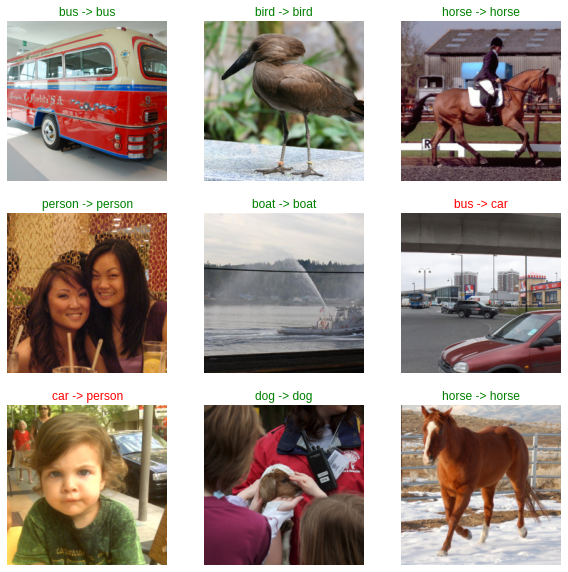

In [12]:
sample = random.sample(range(len(valid_data)), 10)
images, labels = zip(*[(image, label) for image, label in
                                   [valid_data[i] for i in sample]])
outputs = classifier(torch.stack(images).to(device))
predicted = outputs.argmax(dim=1)

plot_images(images, predicted, classes, true_labels=labels)

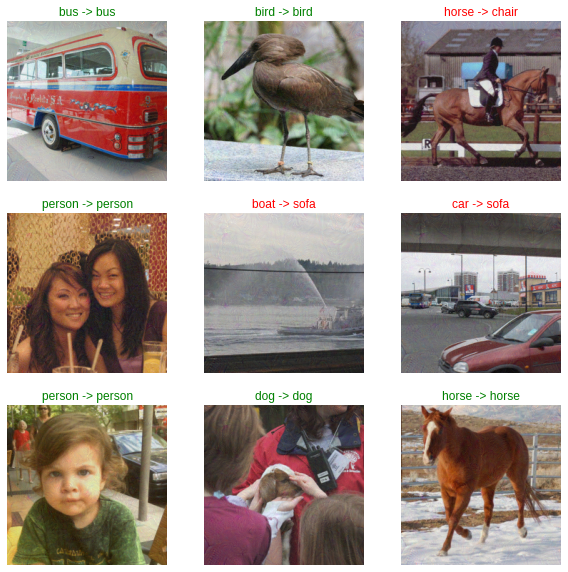

In [13]:
images, labels = zip(*[(image + v.squeeze(), label) for image, label in
                                   [valid_data[i] for i in sample]])

outputs = classifier(torch.stack(images).to(device))
predicted_perturbed = outputs.argmax(dim=1)

plot_images(images, predicted_perturbed, classes, true_labels=predicted)

In [16]:
count = 6
norms = [0, 2000, 4000, 6000, 8000, 10000]
i = 6

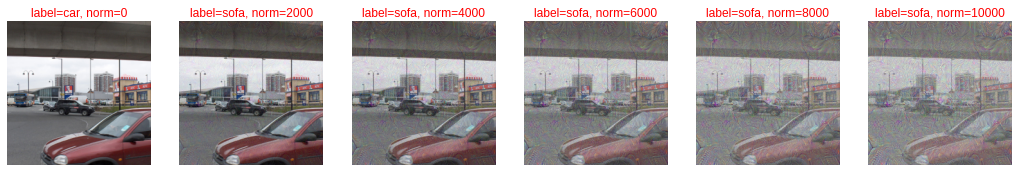

In [21]:
from universal.plot import normalize_image
img, label = valid_data[sample[i]]
imgs_perturbed = []
for norm in norms:
    norm = norm / 255
    normalized_v = v * (norm / np.linalg.norm(v))
    imgs_perturbed.append(img + normalized_v.squeeze())
    
outputs = classifier(torch.stack(imgs_perturbed).to(device))
predicted_perturbed = outputs.argmax(dim=1)
fig, axs = plt.subplots(1, count, figsize=(18, 10))
for i, ax in enumerate(axs):
    ax.imshow(normalize_image(imgs_perturbed[i]).numpy().transpose(1, 2, 0))
    ax.set_title(f"label={classes[predicted_perturbed[i]]}, norm={int(norms[i])}", color= "green" if predicted_perturbed[i] == label else "red")
    ax.set_axis_off()

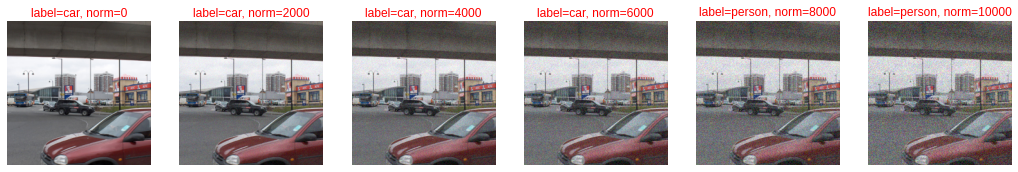

In [22]:
random_v =  np.random.uniform(low=v.min(), high=v.max(), size=(1, 3, 224, 224)).astype(np.float32)
imgs_perturbed = []
for norm in norms:
    norm = norm / 255
    normalized_v = random_v * (norm / np.linalg.norm(random_v))
    imgs_perturbed.append(img + normalized_v.squeeze())
    
outputs = classifier(torch.stack(imgs_perturbed).to(device))
predicted_perturbed = outputs.argmax(dim=1)
fig, axs = plt.subplots(1, count, figsize=(18, 10))
for i, ax in enumerate(axs):
    ax.imshow(normalize_image(imgs_perturbed[i]).numpy().transpose(1, 2, 0))
    ax.set_title(f"label={classes[predicted_perturbed[i]]}, norm={int(norms[i])}", color= "green" if predicted_perturbed[i] == label else "red")
    ax.set_axis_off()

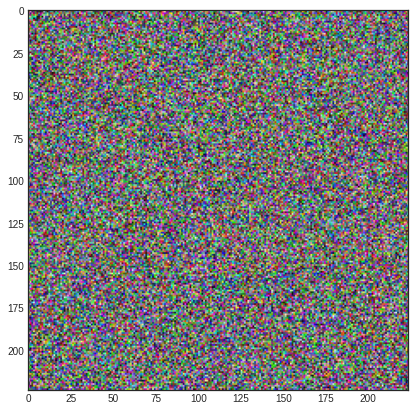

In [19]:
a = random_v.squeeze().transpose(1, 2, 0)

logging.info(f"Perturbation vector norm = {np.linalg.norm(abs(a))}")
a = np.abs(a)
perturbation = (a - np.min(a))/np.ptp(a)
plt.figure(figsize=(7, 7))
plt.imshow(perturbation)

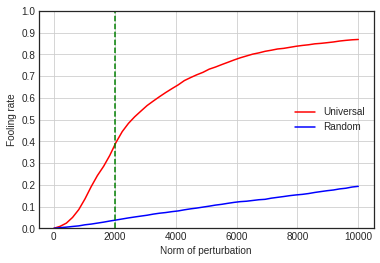

In [50]:
universal, random = np.load("exp1.npy")
norms = np.linspace(0., 10000, 50)
fig, ax = plt.subplots()
ax.plot(norms, universal, color='red', label="Universal")
ax.plot(norms, random, color="blue", label="Random")
ax.set_xlabel("Norm of perturbation")
ax.set_ylabel("Fooling rate")
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(0, 1)
plt.axvline(2000, linestyle='--', color="green")
plt.grid()
ax.legend()

In [56]:
list(range(0,10000, 2000))

[0, 2000, 4000, 6000, 8000]

In [82]:
random

array([0.        , 0.00291946, 0.00532372, 0.00841491, 0.01116263,
       0.01614288, 0.0194058 , 0.02387086, 0.02833591, 0.03348789,
       0.03812468, 0.0429332 , 0.04774171, 0.05203503, 0.05615662,
       0.06010647, 0.06525846, 0.06938004, 0.07247123, 0.07659282,
       0.07985574, 0.08500773, 0.08947278, 0.09307917, 0.09754422,
       0.10183754, 0.10664606, 0.11025245, 0.11488923, 0.11918255,
       0.12261721, 0.12450627, 0.12794092, 0.13137558, 0.13326464,
       0.13858836, 0.14236648, 0.1461446 , 0.15026619, 0.15352911,
       0.1561051 , 0.15988322, 0.16486347, 0.16898506, 0.17293491,
       0.17619784, 0.18117809, 0.18426928, 0.18976473, 0.19302765])

In [33]:
2000 * 100 / (np.linalg.norm(img* 255))

3.581329939463633

In [17]:
import torchvision.transforms as transforms

pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

universal_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.CenterCrop(pretrained_size),
    transforms.ToTensor(),
])

image_filepath = f"/home/waris/demo.jpg"
image = Image.open(image_filepath)
img, label = universal_transforms(image), 1

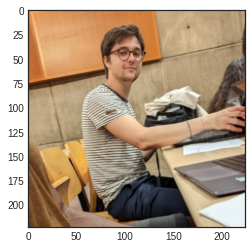

In [22]:
plt.imshow(normalize_image(img).numpy().transpose(1, 2, 0))

In [12]:
imgs_perturbed = []
for norm in norms:
    norm = norm
    normalized_v = v * (norm / np.linalg.norm(v))
    imgs_perturbed.append(img + normalized_v.squeeze())
    
outputs = classifier(torch.stack(imgs_perturbed).to(device))
predicted_perturbed = outputs.argmax(dim=1)
fig, axs = plt.subplots(1, count, figsize=(18, 10))
for i, ax in enumerate(axs):
    ax.imshow(normalize_image(imgs_perturbed[i]).numpy().transpose(1, 2, 0))
    ax.set_title(f"label={classes[predicted_perturbed[i]]}, norm={int(norms[i])}", color= "green" if predicted_perturbed[i] == label else "red")
    ax.set_axis_off()

NameError: name 'norms' is not defined

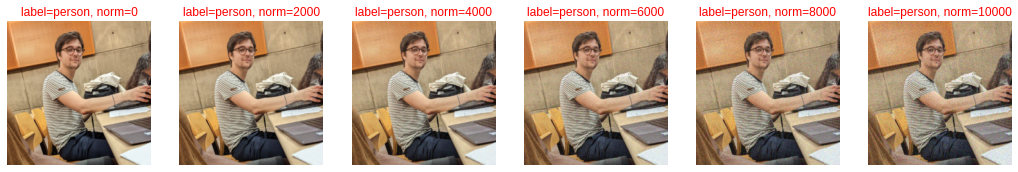

In [23]:
random_v =  np.random.rand(1, 3, 224, 224).astype(np.float32)
imgs_perturbed = []
for norm in norms:
    norm = norm / 255
    normalized_v = random_v * (norm / np.linalg.norm(random_v))
    imgs_perturbed.append(img + normalized_v.squeeze())
    
outputs = classifier(torch.stack(imgs_perturbed).to(device))
predicted_perturbed = outputs.argmax(dim=1)
fig, axs = plt.subplots(1, count, figsize=(18, 10))
for i, ax in enumerate(axs):
    ax.imshow(normalize_image(imgs_perturbed[i]).numpy().transpose(1, 2, 0))
    ax.set_title(f"label={classes[predicted_perturbed[i]]}, norm={int(norms[i])}", color= "green" if predicted_perturbed[i] == label else "red")
    ax.set_axis_off()